## Spectrogram-based classification

Dog disagreement episode:

4/9/show_49NxrBHUtto19pgLNAJkHY/6hoNS9LR1Lxb4EzMX72kXR

In [1]:
import librosa 
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os

# import common analysis functions we've defined
parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)
from common.annotation_utils import tp, get_union

# set plotting style
sns.set(rc = {'figure.figsize':(8,5)})
sns.set_style("white", {'font.family':'serif', 'font.serif':'Times Roman'})
sns.set_context("talk")
sns.set_palette("crest")

EPISODE_ID = "6hoNS9LR1Lxb4EzMX72kXR"
START_MIN = 40
FILE_NAME = f"{EPISODE_ID}.ogg"

# get union of disagreement annotations (pkl generated from compile_annotations.py)
ANNOTATIONS_FILEPATH = '../audio_annotation/compiled_annotations_df.pkl'
annot_df = pd.read_pickle(ANNOTATIONS_FILEPATH)
disagreement_times = get_union(annot_df, EPISODE_ID)

# Load the audio (starting from minute START_MIN) as a waveform "y"
# Store the sampling rate as "sr" (preserve native sampling rate of the file)
start_offset = 60 * START_MIN
y, sr = librosa.load(FILE_NAME, offset = start_offset)

In [2]:
print(f"Shape of waveform:\t\t{y.shape}")
print(f"Sampling rate:\t\t\t{sr}")
print(f"Number of minutes of excerpt:\t{(len(y)/sr)/60:.4f}")

Shape of waveform:		(12148480,)
Sampling rate:			22050
Number of minutes of excerpt:	9.1825


In [445]:
# length of segment (on which to compute each spectrogram) in seconds
SEGMENT_LENGTH_SECONDS = 5
s_length = SEGMENT_LENGTH_SECONDS*sr # length of segments in samples
start_sec = START_MIN * 60

y_chunks = [y[i:i+s_length] for i in range(0, len(y), s_length)]
y_chunks_ts = [tp(start_sec + i*SEGMENT_LENGTH_SECONDS, start_sec + (i+1)*SEGMENT_LENGTH_SECONDS) 
               for i in range(0, len(y_chunks))]
y_labels = 1*np.array([any([t in d for d in disagreement_times]) for t in y_chunks_ts])
print(f"Proportion of chunks which are disagreement: {y_labels.mean():4f}")
print(y_chunks_ts[:5])
print(len(y_chunks_ts))
print(len(y_chunks))

def get_spectrogram(waveform_excerpt, length = s_length, sr = sr):
    # Padding for files w/ less than "length" samples
    zero_padding = np.zeros(length - len(waveform_excerpt))
    padded_waveform = np.concatenate([waveform_excerpt, zero_padding], 0)
    S = librosa.feature.melspectrogram(y = padded_waveform, sr = sr, n_mels = 216)
    return S

Proportion of chunks which are disagreement: 0.315315
[(2400.00,2405.00), (2405.00,2410.00), (2410.00,2415.00), (2415.00,2420.00), (2420.00,2425.00)]
111
111


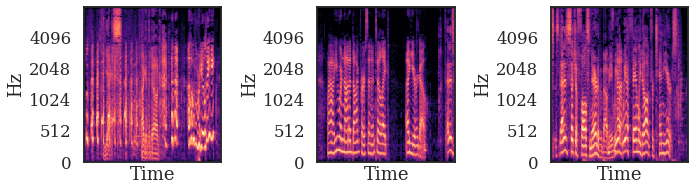

In [1004]:
# Example viz of n disagreement chunks:
n_examples = 3

example_indices = np.argwhere(y_labels == 1)[:n_examples].flatten()
X_examples = [get_spectrogram(y_chunks[i]) for i in example_indices]
fig, axes = plt.subplots(1, n_examples, figsize = (10,3))

for i, ax in enumerate(axes.flat):
    # Convert power spectrogram (amplitude squared) to decibel (dB) units
    s_dB = librosa.power_to_db(X_examples[i], ref=np.max)
    img = librosa.display.specshow(s_dB, x_axis='time',
                             y_axis='mel', sr=sr,
                             fmax=8000, ax = ax)
    ax.set_xticks([]);

#fig.colorbar(img, format='%+2.0f dB')
#fig.suptitle('Mel-frequency spectrogram (disagreement examples)')
fig.tight_layout();

In [447]:
# convolving over full spectrogram, bounding
# viz: inspecting later conv layers
# data augmentation on each audio segments

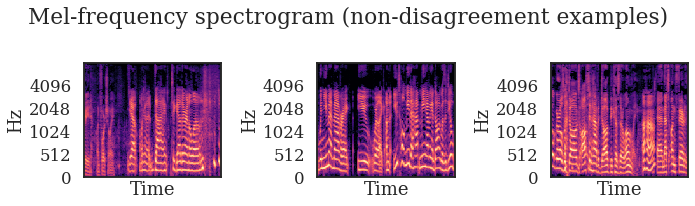

In [1003]:
# Example viz of n non-disagreement chunks:
example_indices = np.argwhere(y_labels != 1)[:n_examples].flatten()
X_examples = [get_spectrogram(y_chunks[i]) for i in example_indices]
fig, axes = plt.subplots(1, n_examples, figsize = (10,3))

for i, ax in enumerate(axes.flat):
    # Convert power spectrogram (amplitude squared) to decibel (dB) units
    s_dB = librosa.power_to_db(X_examples[i], ref=np.max)
    img = librosa.display.specshow(s_dB, x_axis='time',
                             y_axis='mel', sr=sr,
                             fmax=8000, ax = ax)
    ax.set_xticks([]);

#fig.colorbar(img, format='%+2.0f dB')
fig.suptitle('Mel-frequency spectrogram (non-disagreement examples)')
fig.tight_layout();

In [449]:
X = np.array([np.expand_dims(get_spectrogram(i), -1) for i in y_chunks])

In [450]:
print(X.shape)

(111, 216, 216, 1)


In [838]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,roc_curve

X_train, X_test, y_train, y_test = train_test_split(X, y_labels, 
                                                    test_size = 0.2,
                                                    stratify = y_labels,
                                                    shuffle = True,
                                                    random_state=2)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, 
                                                   test_size = 0.3, 
                                                   stratify = y_train,
                                                   shuffle = True,
                                                   random_state=2)

In [839]:
X_train.shape

(61, 216, 216, 1)

In [840]:
X_val.shape

(27, 216, 216, 1)

In [841]:
X_test.shape

(23, 216, 216, 1)

In [842]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

BATCH_SIZE = 16

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

### Related paper: 
"Prediction of User Emotion and Dialogue Success Using Audio
Spectrograms and Convolutional Neural Networks"
https://aclanthology.org/W19-5939.pdf

* "For an 1s long audio file we acquired a resulting 32 bins x 16 frames array (using the default librosa settings ...)"
* 4 convolutional layers with 2-by-2 rectangular filters and a decreasing number of nodes (100-75-50-25), 2-by-2 max pooling and all activation functions being ReLU. This was followed by a batch normalization and 2 fully connected (FCN) layers (also with a decreasing number of nodes, namely 50 and 12 and a dropout of 50%) and an output layer with softmax activation. The stride is always one, padding is always set at “same”, so as that the output has the same length as the original input. As an optimizer, ADAM was used with a learning rate of 0.001, whereas a categorical cross entropy was utilized as the loss function."

In [985]:
for spectrogram, _ in train_ds.take(1):
    input_shape = spectrogram.shape
print("Input shape: ", input_shape)

model = keras.Sequential(
    [
        layers.Conv2D(filters = 2, kernel_size = (5,5), strides = (1,1), activation="relu", padding = 'same'),
        layers.MaxPooling2D(pool_size = (5,5), strides = (4,4)),
        layers.Dropout(0.3),
        layers.Conv2D(filters = 2, kernel_size = (5,5), strides = (1,1), activation="relu", padding = 'same'),
        layers.MaxPooling2D(pool_size = (5,5), strides = (4,4)),
        layers.Dropout(0.3),
        layers.Conv2D(filters = 2, kernel_size = (5,5), strides = (1,1), activation="relu", padding = 'same'),
        layers.MaxPooling2D(pool_size = (5,5), strides = (4,4)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(units = 5, activation = "relu"),
        #layers.Dense(units = 3, activation = "relu"),
        layers.Dense(units = 2)
    ]
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005),  # Optimizer
    # Loss function to minimize
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    # List of metrics to monitor
    metrics=['accuracy'],
)

from sklearn.utils import class_weight
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', 
                                                                 classes = np.unique(y_train),
                                                                 y = y_train)))
print(class_weights)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

EPOCHS = 100
history = model.fit(
    train_ds, 
    validation_data = val_ds,  
    epochs=EPOCHS,
    class_weight = class_weights,
    callbacks=[callback]
)

Input shape:  (16, 216, 216, 1)
{0: 0.7261904761904762, 1: 1.605263157894737}
Epoch 1/100
4/4 [==============================] - 1s 47ms/step - loss: 0.7302 - accuracy: 0.6557 - val_loss: 1.3562 - val_accuracy: 0.3704
Epoch 2/100
4/4 [==============================] - 0s 11ms/step - loss: 0.7228 - accuracy: 0.6557 - val_loss: 1.0707 - val_accuracy: 0.3704
Epoch 3/100
4/4 [==============================] - 0s 12ms/step - loss: 0.6745 - accuracy: 0.6066 - val_loss: 0.9666 - val_accuracy: 0.3704
Epoch 4/100
4/4 [==============================] - 0s 17ms/step - loss: 0.7302 - accuracy: 0.6230 - val_loss: 0.9103 - val_accuracy: 0.3704
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.7727 - accuracy: 0.6066 - val_loss: 0.8716 - val_accuracy: 0.3704
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.7069 - accuracy: 0.6885 - val_loss: 0.8414 - val_accuracy: 0.3704
Epoch 7/100
4/4 [==============================] - 0s 16ms/step - loss: 0.6802 - a

In [986]:
y_test_pred = np.argmax(model.predict(test_ds), axis = 1)

In [987]:
print(np.mean(y_test == y_test_pred))

0.6956521739130435


In [988]:
print(np.mean(y_test))

0.30434782608695654


In [989]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.81      0.79        16
           1       0.50      0.43      0.46         7

    accuracy                           0.70        23
   macro avg       0.63      0.62      0.62        23
weighted avg       0.68      0.70      0.69        23



In [996]:
y_test_pred.sum()

6

In [997]:
y_test.sum()

7

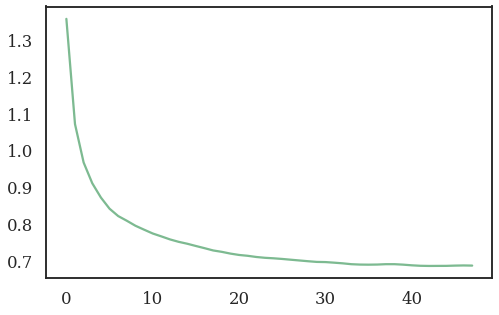

In [998]:
plt.plot(history.history['val_loss'])

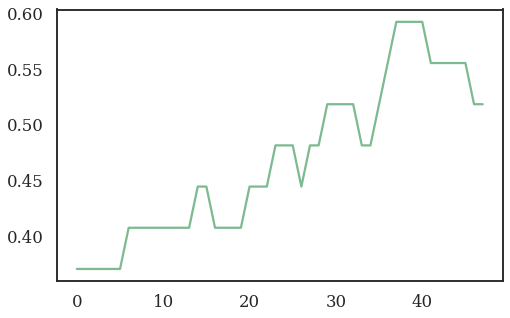

In [999]:
plt.plot(history.history['val_accuracy'])

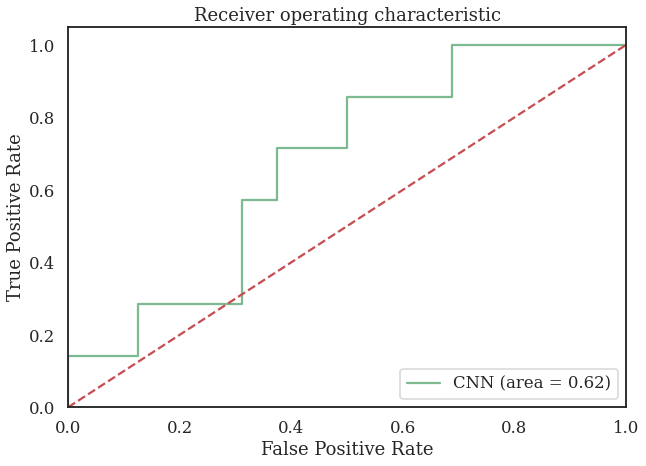

In [1000]:
logit_roc_auc = roc_auc_score(y_test, y_test_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict(test_ds)[:,1])
plt.figure(figsize = (10,7))
plt.plot(fpr, tpr, label='CNN (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [1001]:
print(model.summary())

Model: "sequential_153"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_393 (Conv2D)         (None, 216, 216, 2)       52        
                                                                 
 max_pooling2d_393 (MaxPooli  (None, 53, 53, 2)        0         
 ng2D)                                                           
                                                                 
 dropout_250 (Dropout)       (None, 53, 53, 2)         0         
                                                                 
 conv2d_394 (Conv2D)         (None, 53, 53, 2)         102       
                                                                 
 max_pooling2d_394 (MaxPooli  (None, 13, 13, 2)        0         
 ng2D)                                                           
                                                                 
 dropout_251 (Dropout)       (None, 13, 13, 2)      

In [514]:
# # augmentation of spectrograms, Google AI blog
# # https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html

# # using github implementation from https://github.com/DemisEom/SpecAugment
# # also following tensorflow tutorial at: https://www.tensorflow.org/tutorials/images/data_augmentation

# def random_invert(factor=0.5):
#     return layers.Lambda(lambda x: random_invert_img(x, factor))

# class RandomInvert(layers.Layer):
#     def __init__(self, factor=0.5, **kwargs):
#         super().__init__(**kwargs)
#         self.factor = factor

#     def call(self, x):
#         return random_invert_img(x)

# data_augmentation = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
# ])